# First introduction to GZ2 Merger data

In this notebook we use the Galaxy Zoo 2 dataset and plot some data on the merger vote fraction

The GZ2 data can be found at https://data.galaxyzoo.org/
<br>
We are using Table 5 in this notebook

First we import the necessary packages and import the database into an Astropy Table "gz2_data".

We print the info of the table to get the column names we are interested in.

In [1]:
from astropy.table import Table
from astropy.table import Column
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Import gz2 data as a table
# filename = "GZ Data\gz2_hart16.fits" # Table 1
filename = "GZ Data\zoo2MainSpecz.fits" # Table 5

with fits.open(filename) as data:
    gz2_data = Table(data[1].data)

print(gz2_data.info())

<Table length=243500>
                             name                              dtype 
------------------------------------------------------------- -------
                                                    specobjid   int64
                                                     dr8objid   int64
                                                     dr7objid   int64
                                                           ra float32
                                                          dec float32
                                                     rastring   str11
                                                    decstring   str11
                                                       sample   str20
                                                     gz2class   str20
                                        total_classifications   int16
                                                  total_votes   int16
                      t01_smooth_or_features_a01_smooth_count   int1

We are interested in the debiased merger vote fraction, $p_m$, so create a new table containing only that data, "merger_debiased".

We change the name of the column to something more readable and useful.

In [2]:
# Filter out debiased merger vote fraction only
merger_debiased = Table([gz2_data["t08_odd_feature_a24_merger_debiased"]])
merger_debiased["t08_odd_feature_a24_merger_debiased"].name = "Merger Vote Fraction Debiased"
merger_debiased.info

<Table length=243500>
             name              dtype 
----------------------------- -------
Merger Vote Fraction Debiased float32



Now we have the data we need in the table "merger_debiased", we plot two graphs of the number of galaxies against the merger vote fraction.
<br>
The first graph is of every galaxy in the data set, the second is with only non-zero merger vote fractions

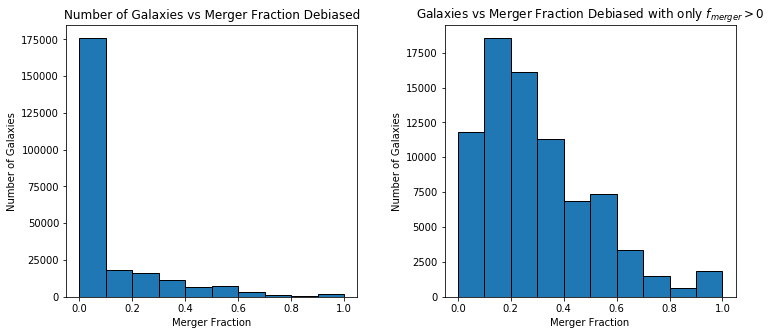

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Plot histogram of entire gz2 data merger fraction
ax[0].hist(merger_debiased["Merger Vote Fraction Debiased"],  bins=10, range=(0,1), edgecolor="black")
ax[0].set_xlabel("Merger Fraction")
ax[0].set_ylabel("Number of Galaxies")
ax[0].set_title("Number of Galaxies vs Merger Fraction Debiased")

# Plot historgram of gz2 data with non zero merger fraction
merger_debiased_nonzero = merger_debiased[merger_debiased["Merger Vote Fraction Debiased"] > 0]
ax[1].hist(merger_debiased_nonzero["Merger Vote Fraction Debiased"], bins=10, range=(0,1), edgecolor="black")
ax[1].set_xlabel("Merger Fraction")
ax[1].set_ylabel("Number of Galaxies")
ax[1].set_title("Galaxies vs Merger Fraction Debiased with only $f_{merger} > 0$")
fig.subplots_adjust(wspace=0.3)

We can see there is a large difference between the two graphs. The first has a very large skew towards a vote fraction $p_m=0$. These are galaxies in the data set which have had no votes for being a merger from the GZ2 users.
<br>
Once we filter out these galaxies, as they are not of any interest to us (we can accurately conclude they are definitely not mergers), the spread of merger vote fractions is much clearer. There are many galaxies with low vote fractions $(p_m<0.4)$ and far fewer with high vote fractions $(p_m>0.7)$.
<br>
There is a peak at the very last bin for galaxies with vote fractions $0.9 < p_m \leq 1$. It is unlikely to have such a high vote fraction (especially a vote fraction $p_m=1$) when around 40 users are classifying each galaxies. I suspect many of these galaxies are in fact not mergers, but only have a single vote for the "anything odd?" question in the GZ2 classification, and this single vote has also been for a merger. As there is only one vote for anything odd, and this is also a merger vote, the vote fraction is 1, however the other GZ2 users have correctly identified the galaxy as "normal" but they show as a peak in the graph nonetheless. We will try to eliminate these galaxies later.

Below we plot the second graph again with labels above each bin of the histogram giving the number of galaxies in that bin.

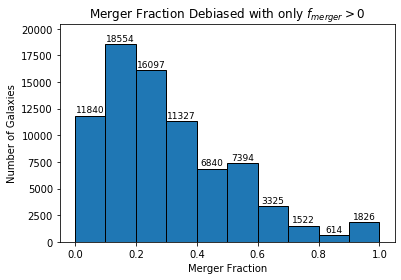

In [4]:
# Plot same second graph as above with labels for number of galaxies in bin
num_of_bins = 10
fig2 = plt.hist(merger_debiased_nonzero["Merger Vote Fraction Debiased"], bins=num_of_bins, range=(0,1), edgecolor="black")
plt.xlabel("Merger Fraction")
plt.ylabel("Number of Galaxies")
plt.title("Merger Fraction Debiased with only $f_{merger} > 0$")
plt.ylim(0, max(fig2[0])*1.1)
for i in range(num_of_bins):
    plt.text((fig2[1][i] + fig2[1][i+1]) / 2,fig2[0][i]+max(fig2[0])/60,str(int(fig2[0][i])), fontsize=9, ha='center')
plt.show()

# Resampling the data to only include more certain mergers

Here we go back to the original dataset, but only select galaxies which have at least 10 votes by GZ2 users for being a merger. As explained before, we expect this to eliminate galaxies with high merger fractions, but low numbers of counts for "anything odd".

We select galaxies which have at least 10 votes for being a merger, and call this table "mergers". We print the number of galaxies that satisfy this criteria.

In [5]:
# Resample data for only galaxies which have merger_flag = 1, and that have a minimum number of merger votes

# greater_than_1 = gz2_data[gz2_data["t08_odd_feature_a24_merger_count"] > 1]
# mergers = greater_than_1[greater_than_1["t08_odd_feature_a24_merger_debiased"] == 1]

# mergers = gz2_data[gz2_data["t08_odd_feature_a24_merger_flag"] == 1]
mergers = Table(gz2_data)
mergers = mergers[mergers["t08_odd_feature_a24_merger_count"] >= 10]
# mergers = mergers[mergers["t06_odd_a14_yes_count"] >= 40]
# mergers = mergers[mergers["t08_odd_feature_a24_merger_debiased"] == 0]

print("Number of galaxies with merger fraction > 10: " + str(len(mergers)))

Number of galaxies with merger fraction > 10: 9158


We again plot the number of galaxies against merger vote fraction with the reduced set of galaxies.

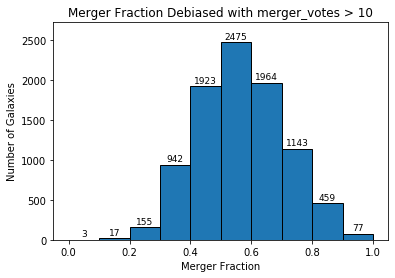

In [6]:
num_of_bins = 10
fig3 = plt.hist(mergers["t08_odd_feature_a24_merger_debiased"], bins=num_of_bins, range=(0,1), edgecolor="black")
plt.xlabel("Merger Fraction")
plt.ylabel("Number of Galaxies")
plt.title("Merger Fraction Debiased with merger_votes > 10")
plt.ylim(0, max(fig3[0])*1.1)
for i in range(num_of_bins):
    plt.text((fig3[1][i] + fig3[1][i+1]) / 2,fig3[0][i]+max(fig3[0])/60,str(int(fig3[0][i])), fontsize=9, ha='center')
plt.show()

The histogram is now very different to that of before. Noteably we have gotten rid of almost all galaxies with vote fractions $p_m<0.2$, and greatly reduced the number of galaxies with vote fraction $p_m<0.6$.
<br>
We have also removed all of the high vote fraction galaxies with very few merger votes successfully, there are now only have 77 galaxies in the top bin $0.9 < p_m \leq 1$ compared to 1826 previously.

We now choose one of these 9158 galaxies with a vote fraction $p_m>0.9$, get the right ascension (ra) and declination (dec) of the galaxy, and show an image of it from the Sloan Digital Sky Survey (SDSS) catalogue.

http://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra=195.6014&dec=32.914932&scale=0.39612&width=400&height=400&opt=&query=


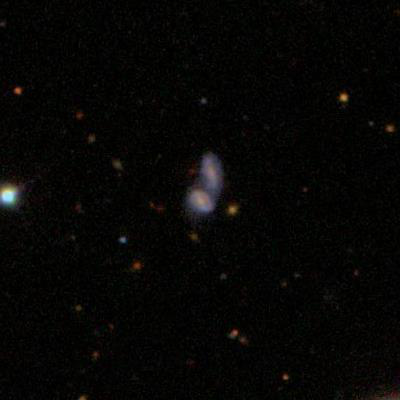

In [19]:
import random

mergers = mergers[mergers["t08_odd_feature_a24_merger_debiased"] > 0.9]

mergers_index = random.randint(0, len(mergers))

url1 = "http://skyservice.pha.jhu.edu/DR7/ImgCutout/getjpeg.aspx?ra="
ra = mergers["ra"][mergers_index]
url2 = "&dec="
dec = mergers["dec"][mergers_index]
url3 = "&scale=0.39612&width=400&height=400&opt=&query="
url = url1 + str(ra) + url2 + str(dec) + url3
print(url)

import urllib.request
from PIL import Image
image = Image.open(urllib.request.urlopen(url))
image

In [8]:
# anything_odd_yes = gz2_data[gz2_data["t06_odd_a14_yes_flag" == 1]]
print(len(gz2_data[gz2_data["t06_odd_a14_yes_flag"] == 1]))
print(len(gz2_data[gz2_data["t06_odd_a14_yes_debiased"] >= 0.8])) # not the same length, different thresholds used
# print((gz2_data[gz2_data["t06_odd_a14_yes_flag"] == 1] == gz2_data[gz2_data["t06_odd_a14_yes_debiased"] > 0.8]).all())

print(len(gz2_data[gz2_data["t08_odd_feature_a24_merger_flag"] == 1]))
print(len(gz2_data[gz2_data["t08_odd_feature_a24_merger_debiased"] >= 0.8]))# not the same length, different thresholds used
# print((gz2_data[gz2_data["t08_odd_feature_a24_merger_flag"] == 1] == gz2_data[gz2_data["t08_odd_feature_a24_merger_debiased"] >= 0.8]).all())
# merger flag does either consider merger votes or "anything odd" votes, unlike Table 1, hence we see different plots

7368
7377
513
2440


8414


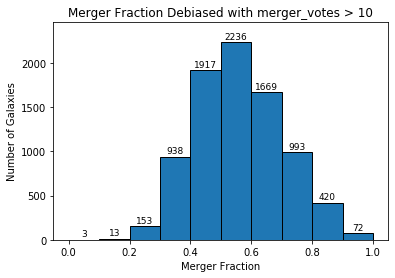

In [22]:
merger_flag_1 = gz2_data[gz2_data["t06_odd_a14_yes_debiased"] > 0.420]
merger_flag_1 = merger_flag_1[merger_flag_1["t06_odd_a14_yes_count"] >= 20]
# merger_flag_1 = merger_flag_1[merger_flag_1["t08_odd_feature_a24_merger_debiased"] > 0.2]
# merger_flag_1 = merger_flag_1[merger_flag_1["t08_odd_feature_a24_merger_flag"] == 0]
# merger_flag_1 = merger_flag_1[merger_flag_1["t08_odd_feature_a24_merger_debiased"] > 0.420]
merger_flag_1 = merger_flag_1[merger_flag_1["t08_odd_feature_a24_merger_count"] >= 10]
print(len(merger_flag_1))

num_of_bins = 10
fig3 = plt.hist(merger_flag_1["t08_odd_feature_a24_merger_debiased"], bins=num_of_bins, range=(0,1), edgecolor="black")
plt.xlabel("Merger Fraction")
plt.ylabel("Number of Galaxies")
plt.title("Merger Fraction Debiased with merger_votes > 10")
plt.ylim(0, max(fig3[0])*1.1)
for i in range(num_of_bins):
    plt.text((fig3[1][i] + fig3[1][i+1]) / 2,fig3[0][i]+max(fig3[0])/60,str(int(fig3[0][i])), fontsize=9, ha='center')
plt.show()